# K-means Clustering

K Means is an algorithm to determine clusters for data, which is motivated by the idea that the distance between a point and the points in its assigned cluster should be small compared to the distance between a point and those that are not in its cluster. That is, the inter-point distances should be small compared to the intra-point distances. All that remains is to mathematically represent this.

Suppose we have a set of data points $\textbf{x} = (\textbf{x}_{1}, ... , \textbf{x}_{N})$ which are $D$ dimensional. We can represent the centers of our clusters with $\mu_{k}$ for $k = 1, ... , K$. For now we can assume $K$ is given to us, as deciding on a $K$ is another problem involving cross-validation.

To represent the assignment of $\textbf{x}_{n}$ to a cluster $k$, we can use indicator variables $r_{nk}$ such that 
$$r_{nk} = \begin{cases}
                1 & \text{if } \textbf{x}_{n} \in \text{cluster k} \\
                0 & \text{o.w.}
           \end{cases}$$
                
Finally, we can describe the error of our assignment using the squared distances between points and their assigned cluster center $\mu_{k}$, which can be summed up in the function 
$$ J = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} \|\textbf{x}_{n} - \mu_{k}\|^2$$

We now have all the pieces to formulate the algorithm. Note that our error function $J$ cannot simply be differentiated with respect to $\mu_{k}$ and $r_{nk}$ because the latter is discrete. Instead, we need to iteratively update $J$ using the following steps.

1. Initialize $\mu_{k}$. The method we will be using is to just sample $K$ of our data points. 


2. For each n there can only be one $r_{nk}$ that equals $1$. So we assign $k = \underset{j}{\arg\max} \|\textbf{x}_{n} - \mu_{j}\|^2$, which assigns the point $x_{n}$ to the cluster whose center is closest to it.


3. Fixing $r_{nk}$, we can now differentiate $J$ with respect to $\mu_{k}$ and set equal to $0$, which yields
$$ -2 \sum_{n=1}^{N} r_{nk} ( \textbf{x}_{n} - \mu_{k} ) = 0$$

$$\implies\mu_{k} = \frac{\sum_{n=1}^{N} r_{nk} x_{n}}{\sum_{n=1}^{N} r_{nk}}$$

Intuitively, this updates each center to be the mean of the points assigned to it (and is the namesake of the algorithm).

4. If the centers don't change after step 3, terminate. Otherwise repeat steps 2 and 3.

This algorithm is pretty straightforward logically. We will now implement it.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
def simplekmeans(data, k):
    # step 1
    #fig, ax = plt.subplots(3,3, figsize=(15,13))
    centers = data[np.random.randint(data.shape[0], size=k), :]
    newcenters = np.zeros(centers.shape)
    abort = 0
    while(True):
        # step 2
        temp = np.empty([len(centers), len(data)])
        for i in np.arange(len(centers)):
            temp[i] = np.linalg.norm(data - centers[i], axis=1)
        dist = pd.DataFrame(temp.T)
        rnk = np.array(dist.idxmin(axis=1))
        
        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], c=rnk, cmap='rainbow')
        plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='black')
        
        if(abort):
            return(newcenters, rnk)
        
        # step 3
        for i in np.arange(len(centers)):
            newcenters[i] = np.sum(data[np.where(rnk==i)[0], :], axis=0) / len(np.where(rnk==i)[0])
        #print(newcenters)
        
        if(np.array_equal(centers, newcenters)):
            abort = 1
        else:
            centers = newcenters
    return(newcenters, rnk)

Here we initialize the centers by sampling $K$ data points as described above. To compare the updated centers with the old ones, we will assign the new ones to a separate variable. 

Since we require the algorithm to run at least once, we implement a do-while loop. Within this loop we start with step 2, where we calculate the distances between the data points and each center, storing each as a column in a dataframe. We then extract the index of the minimum of each row, which effectively assigns each data point to a cluster from $0$ to $K-1$. 

Moving on to step 3, we update the centers by assigning them to the mean of the points in the corresponding clusters. If these new centers are the same as the old ones, we signal the loop to terminate. However, before terminating we need to update the labels one more time, and so the breakpoint needs to be placed between step 2 and step 3.

In [3]:
c1numpoints = 10
c2numpoints = 10
c3numpoints = 10

mu1 = np.array([1, 2])
sigma1 = np.array([[1, 0.5], [0.5, 1]])
c1 = np.random.multivariate_normal(mu1, sigma1, c1numpoints)

mu2 = np.array([1, -2])
sigma2 = np.array([[1, 0.5], [0.5, 1]])
c2 = np.random.multivariate_normal(mu2, sigma2, c2numpoints)

mu3 = np.array([5, -2])
sigma3 = np.array([[1, 0.5], [0.5, 1]])
c3 = np.random.multivariate_normal(mu3, sigma3, c3numpoints)

x = np.vstack((c1, c2, c3))
#plt.plot(c1[:, 0], c1[:, 1], 'bo')
#plt.plot(c2[:, 0], c2[:, 1], 'rx')
#plt.plot(c3[:, 0], c3[:, 1], 'g+')

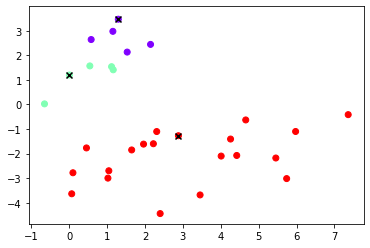

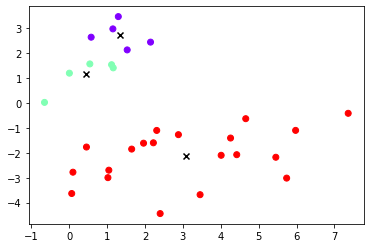

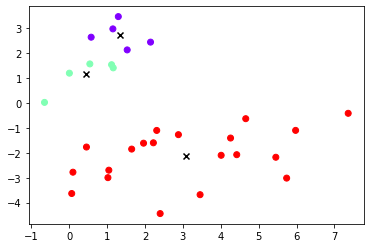

In [4]:
center, labels = simplekmeans(x, 3)

If you run this algorithm multiple times you might notice that sometimes the algorithm fails to finish running. The issue is probably due to nature of our initialization of the centers. Because we are assigning them to be randomly sampled data points, it is possible for two means to be assigned the same data point. Therefore we should sample without replacement. 

Another issue is that sometimes the algorithm converges, but the resulting centers and labels seem nonsensical. This is due to the fact that K-means locally converges but does not always globally converge due to being a nonparametric method. We can overcome this by running the algorithm multiple times and selecting the centers and labels from the model with the smallest error. K-means algorithms that take more than 10 or so steps will probably not converge optimally, and so we can cap the number of iterations at 10 for each algorithm.

Let's redefine our K-means with these changes:

In [5]:
def calcerror(data, rnk, centers):
    err = 0.0
    for i in np.arange(len(centers)):
        err = err + np.sum((np.linalg.norm(data[np.where(rnk==i)[0], :] - centers[i], axis=1))**2, axis=0)
    return err

def kmeans(data, k):
    num = 5  
    error = -1
    fincenters = None
    finrnk = None
    
    # run 5 models and only update the final centers and labels if the error is lower than the previous
    for l in np.arange(num):
        # step 1
        centers = data[random.sample(range(data.shape[0]), k), :]
        newcenters = np.zeros(centers.shape)
        abort = 0    
        # cap the algorithm at 10 iterations, any more and it will just use up computational time
        for j in np.arange(10):
            # step 2
            temp = np.empty([len(centers), len(data)])
            for i in np.arange(len(centers)):
                temp[i] = (np.linalg.norm(data - centers[i], axis=1))**2
            dist = pd.DataFrame(temp.T)
            rnk = np.array(dist.idxmin(axis=1))

            if(abort):
                break
            # step 3
            for i in np.arange(len(centers)):
                newcenters[i] = np.sum(data[np.where(rnk==i)[0], :], axis=0) / len(np.where(rnk==i)[0])

            if(np.array_equal(centers, newcenters)):
                abort = 1
            centers = newcenters
            
        if(error == -1):
            error = calcerror(data, rnk, centers)
            fincenters = centers
            finrnk = rnk
        elif(error > calcerror(data, rnk, centers)):
            fincenters = centers
            finrnk = rnk
            error = calcerror(data, rnk, centers)
            
    return(fincenters, finrnk)

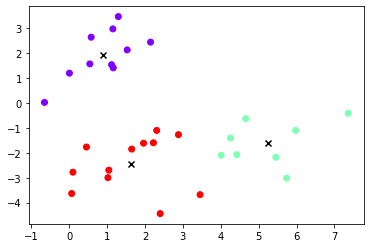

In [6]:
centers, labels = kmeans(x, 3)
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='black')

Now our algorithm will almost always give a reasonable clustering of our data points. Unfortunately we cannot plot the steps of the most successful K-means iteration unless we store all the data for each step of each iteration, which would require a ton of storage. To visualize the K-means iterations we'll have to stick with our first version of it.

There is also another implementation of K-means where we iteratively update the cluster centers rather than recompute them each time, which can potentially make our algorithm much faster for large or high dimensional data sets.